In [54]:
import re
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from tabulate import tabulate
from collections import Counter
from wordcloud import WordCloud


## Before Start working on the model will show you how we have extracted the data and did data preparation

### We have scrap the data by hitting the Google News Library of the python

In [55]:
#Method which we have created the for scarping the data from Google news,Each time it gets called will
# give 2000 records with respect to the category we specifies 

from GoogleNews import GoogleNews

total_news_results = []

def scrape_google_news_records(category):
    object_google = GoogleNews()
    object_google.set_lang('en')
    object_google.search(category)
    

    records_per_page = 10
    current_page = 1
    desired_records=2000
    
    while len(total_news_results) < desired_records:
        object_google.getpage(current_page)
        page_results = object_google.results()
        
        if len(page_results) == 0:
            break
        
        total_news_results.extend(page_results)
        
        if len(total_news_results) >= desired_records:
            break
        
        current_page += 1
    
    return total_news_results

### The result we get is in JSON format so we are converting it into a dataframe for further processing

In [56]:
# Also i have commented out the code to avoid getting duplicate records and to avoid hitting the 
# google news API multiple times and modification in the data, beacuse every time it hits it gives us
# new records

In [57]:
category = 'sports'
news_records = scrape_google_news_records(category)
sports_df= pd.DataFrame(total_news_results)

<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>


In [58]:
category = 'politics'
#news_records = scrape_google_news_records(category)
politics_df= pd.DataFrame(total_news_results)

In [59]:
category = 'entertainement'
#news_records = scrape_google_news_records(category)
entertainement_df= pd.DataFrame(total_news_results)

In [60]:
category = 'Business'
#news_records = scrape_google_news_records(category)
Business_df= pd.DataFrame(total_news_results)

In [61]:
category = 'religion'
#news_records = scrape_google_news_records(category)
religion_df= pd.DataFrame(total_news_results)

In [62]:
# Now after getting the different category data into different data frame
# Each dataframe gets a new category column with its category so that we can join the data 

In [63]:
sports_df['category'] = 'SPORTS'
politics_df['category'] = 'POLITICS'
entertainement_df['category'] = 'ENTERTAINMENT'
Business_df['category'] = 'BUSINESS'
religion_df['category'] = 'RELIGION'

In [64]:
# now we have data frames with there category 
sports_df['category'][1]

IndexError: index 1 is out of bounds for axis 0 with size 0

In [ ]:
#After this i have joined the dataframes into One 
df_all=pd.concat([sports_df, politics_df,entertainement_df,Business_df,religion_df], ignore_index=True)

In [ ]:
# here we only need text columns and Category column, so dropping the other columns
df_all.drop(columns=['media','date','datetime','link','img'],inplace=True)

In [ ]:
# Now we have two columns that are in test so joining them and creating a new column 
df_all['Text']=df_all['title']+' '+df_all['desc']

In [ ]:
# Dropping those dupliacted columns
no_columnc=['title','desc']
df_all=df_all.drop(columns= no_columnc)

In [ ]:
# To avoid making the data Bias while splitting for Train and Test 
# We have shuffled the records randomly
df_all = df_all.sample(frac=1, random_state=78).reset_index(drop=True)

In [ ]:
# Finally this is how our data looks like
df_all.info()

In [ ]:
# To avoid Dulication and loss of the data, we have saved in into the csv file

# commenting the code to avoid genearting of the of multiple files 
#  df_all.to_csv("Scrap category data of english.csv")

##  Now the Actual Making of the Model Starts

In [65]:
df=pd.read_csv("Scrap category data of english.csv")

In [66]:
df.head()

,category,Text
0,POLITICS,Sean Hannity Says Trump 'Needs To Pardon' Hims...
1,POLITICS,"Anthony Fauci Delivers Short, Sharp Shutdown O..."
2,BUSINESS,10 Startup Practices That Usually Lead to Disa...
3,POLITICS,Christian Songwriter Is Fed Up With Believers ...
4,ENTERTAINMENT,What To Watch On Hulu That’s New This Week A d...


## Check the count of the Category 

In [67]:
df['category'].value_counts()

RELIGION         2102
SPORTS           2091
ENTERTAINMENT    2073
POLITICS         2020
BUSINESS         2011
Name: category, dtype: int64

## visualization of the category and count of the records

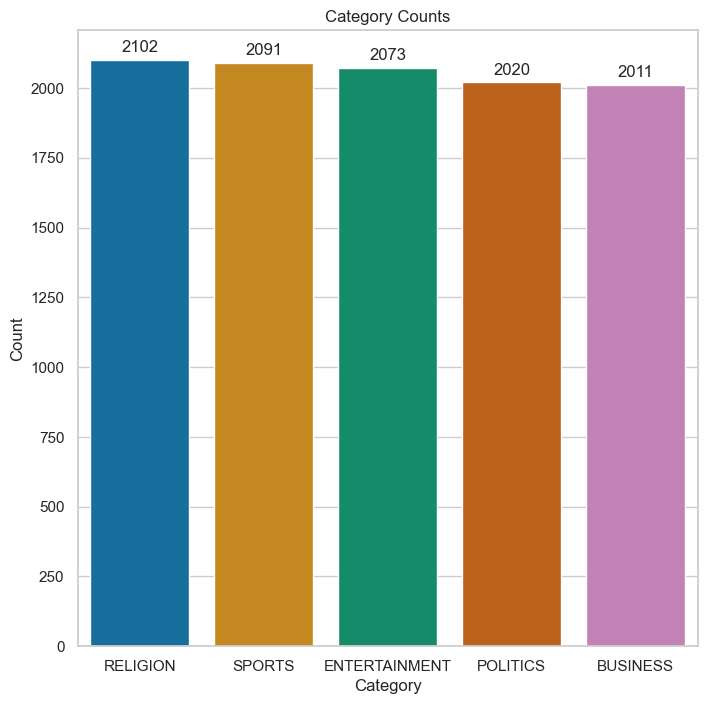

In [68]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
ax = sns.barplot(x=df['category'].value_counts().index, y=df['category'].value_counts().values, palette="colorblind")
ax.set(xlabel='Category', ylabel='Count', title='Category Counts')

for i, v in enumerate(df['category'].value_counts().values):
    ax.text(i, v + 50, str(v), ha='center', va='center_baseline')

plt.show()


In [69]:
df.describe().transpose()

,count,unique,top,freq
category,10297,5,RELIGION,2102
Text,10297,10290,This Week In Pictures: Faith In Practice Aroun...,8


# Preprocessing the data 

## Checking missing values

In [70]:
df.isnull().mean()

category    0.0
Text        0.0
dtype: float64

## check for Duplicate and remove them 

In [71]:
df.duplicated().sum()

7

In [72]:
df.drop_duplicates(inplace=True)

# Label Encoding


In [73]:
# converting the category column into numeric by applying label encoder
label_encoder = LabelEncoder()
df['encoded_category'] = label_encoder.fit_transform(df['category'])

# Different Methods that are used for preprocessing

## Function to convert text to lowercase,remove (/r, /n carriage and newline characters),URL,Numbers and punctuations

In [74]:
def clean_function(string):
    string = string.replace('\r','').replace('\n',' ').lower()
    string = re.sub(r'http[s]?://\S+|www\.\S+','',string)
    string = re.sub(r'\d+','',string)
    string = re.sub(r'[^\w\s]', '', string)
    return string

## Function for tokenizing the words 

In [75]:
def tokenize_words(string):
    tokenized_word = word_tokenize(string)
    return tokenized_word
    

## Function for removing Stop words

In [76]:
def stopwords_func(tokenized_word):
    filtered_token = []
    stopword_list = stopwords.words('english')
    for i in tokenized_word:
        if i not in stopword_list:
            filtered_token.append(i)
    return filtered_token

## Function for removing special characters

In [77]:
def special_char(string):
    string = re.sub(r'[^\w\s#@$]|#\S+', '', string)
    return string

## Function for applying lemmitization

In [78]:
def lemmitization(tokenized_string1):
    lemitization_list=[]
    lem=WordNetLemmatizer()
    lemmatized_words = [lem.lemmatize(word,pos='v') for word in tokenized_string1]
        
    return lemmatized_words

In [79]:
#convert text to lowercase,remove (/r, /n carriage and newline characters),
#URL,Numbers and punctuations

df['clean_text']=df['Text'].apply(clean_function)
print(df['clean_text'][5])

daily meditation spark creativity we all need help maintaining our personal spiritual practice we hope that these daily meditations prayers and mindful awareness


In [80]:
# Removing Special characters
df['clean_text']=df['clean_text'].apply(special_char)
print(df['clean_text'][5])

daily meditation spark creativity we all need help maintaining our personal spiritual practice we hope that these daily meditations prayers and mindful awareness


In [81]:
#tokenize the words
df['clean_text']=df['clean_text'].apply(tokenize_words)
print(df['clean_text'][5])

['daily', 'meditation', 'spark', 'creativity', 'we', 'all', 'need', 'help', 'maintaining', 'our', 'personal', 'spiritual', 'practice', 'we', 'hope', 'that', 'these', 'daily', 'meditations', 'prayers', 'and', 'mindful', 'awareness']


In [82]:
#removing stop words
df['clean_text']=df['clean_text'].apply(stopwords_func)
print(df['clean_text'][5])

['daily', 'meditation', 'spark', 'creativity', 'need', 'help', 'maintaining', 'personal', 'spiritual', 'practice', 'hope', 'daily', 'meditations', 'prayers', 'mindful', 'awareness']


In [83]:
# Lemmitization 
df['clean_text']=df['clean_text'].apply(lemmitization)
print(df['clean_text'][5])

['daily', 'meditation', 'spark', 'creativity', 'need', 'help', 'maintain', 'personal', 'spiritual', 'practice', 'hope', 'daily', 'meditations', 'prayers', 'mindful', 'awareness']


## Visualizing the length of the words present in the Clean text 

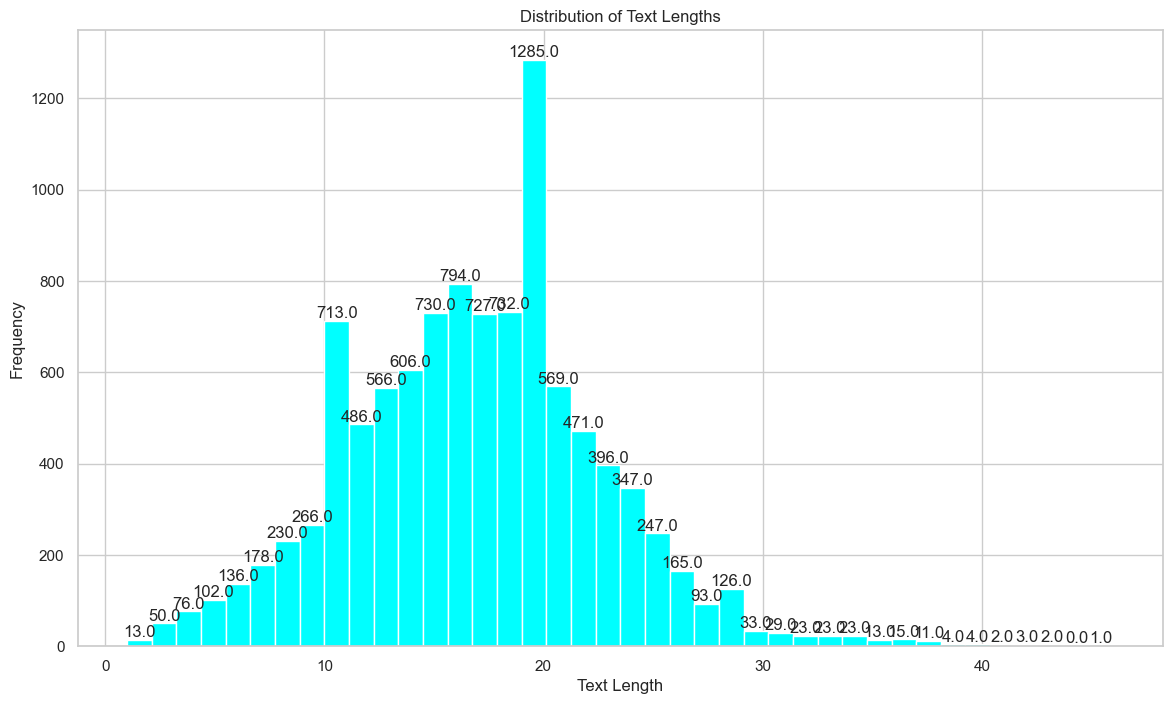

In [84]:
lengths_of_clean_text = df['clean_text'].apply(len)


# Plotting the histogram
plt.figure(figsize=(14, 8))
counts, bins, patches = plt.hist(lengths_of_clean_text, bins=40, color='cyan')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')

# Adding count labels to the bars
for count, patch in zip(counts, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height, count,
             ha='center', va='bottom')

plt.show()

## Function for creating the a seperate table for the Top  30 words and the Count of it Based upon the category 

In [85]:
# Here we are creating a new data frame category_type so that we can get the records related to one category from the 
# clean_text column, then again creating a new data Frame top_words so that we can get the top words and their count
def get_top_words_by_category(df, category, top_n=30):
    category_type = df[df['category'] == category]
    words = [item for sublist in category_type['clean_text'] for item in sublist]
    word_counts = Counter(words)
    top_words = pd.DataFrame(word_counts.most_common(top_n), columns=['Top Words', 'Count'])
    return top_words

## Function for creating the bar plot for the Top Words and Count based upon the category 

In [86]:
# After receiving the top words and count plotting a bar chart based upon the category 
def plot_top_words(top_words, category):
    plt.figure(figsize=(25, 8))
    plt.bar(top_words['Top Words'], top_words['Count'], color='green',width=0.8)
    plt.xlabel('Top Words')
    plt.ylabel('Count')
    plt.title(f'Top Words in {category}')
    plt.xticks(rotation=90,fontsize=22)
    plt.show()

## Function for Creating the word cloud of the  different categories with its top words 

In [87]:
# Using the above top words and categroy to the word cloud 
def generate_word_cloud(top_words, category):
    # Create a dictionary of word-frequency pairs
    word_freq = dict(zip(top_words['Top Words'], top_words['Count']))

    # Generate the word cloud
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_freq)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    plt.show()

## Function for Plotting the confusion matrix 

In [88]:
def conf_matrix(y_true, y_pred,con_value):
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(6, 4))

    # Plot the confusion matrix using a heatmap
    sns.heatmap(con_value, annot=True, fmt='d', cmap='Blues', ax=ax)

    # Set labels, title, and ticks
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    
    ax.set_xticklabels(df['category'].unique(),fontsize=6)
    ax.set_yticklabels(df['category'].unique(),fontsize=6)
    
    plt.show()

# RELIGION

,Top Words,Count
0,pope,289
1,church,250
2,people,202
3,francis,197
4,daily,192
5,say,190
6,us,188
7,religious,162
8,need,152
9,god,152


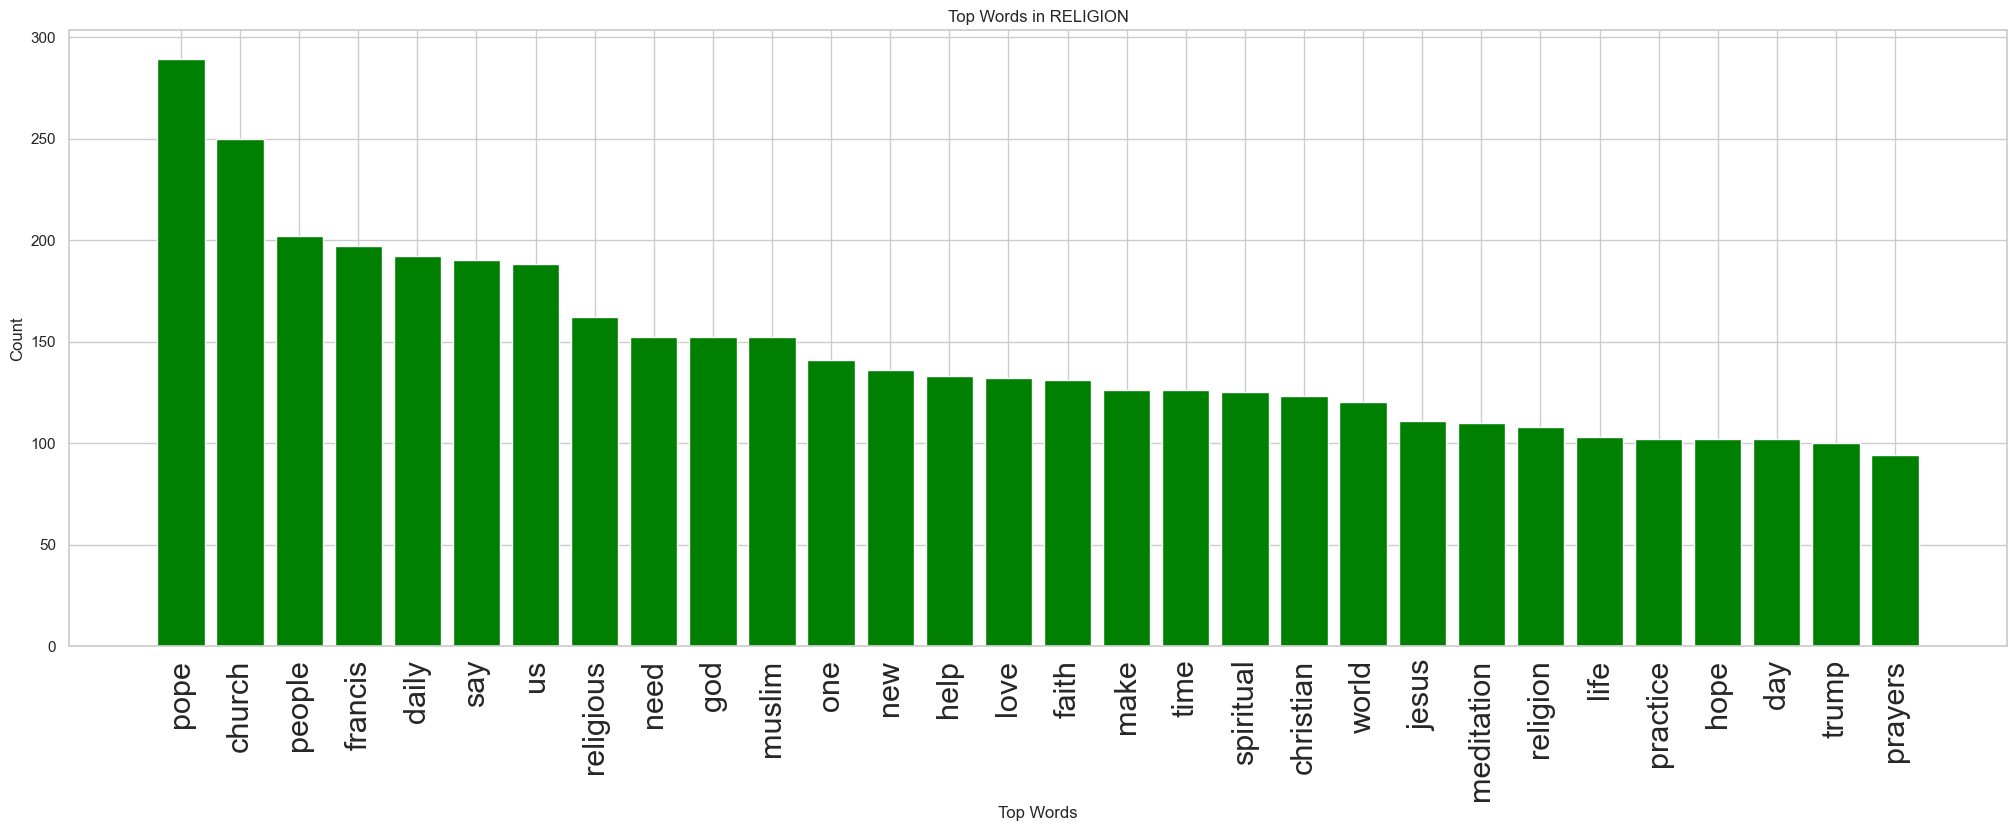

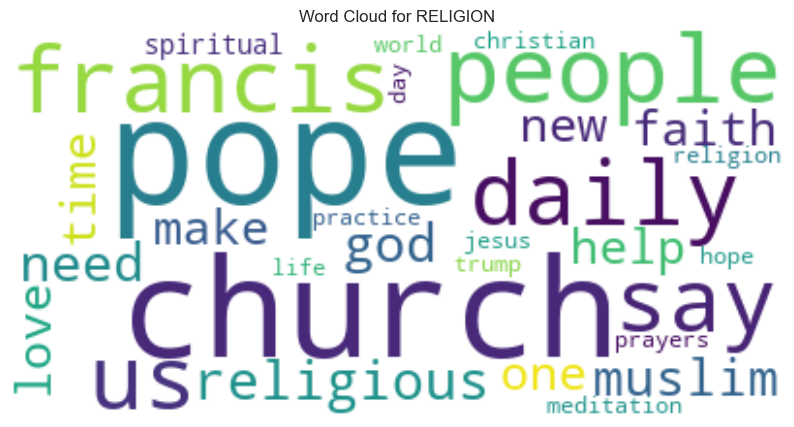

In [89]:
#Here for first category we are calling all the three function for creating the table, Bar graph and Word cloud
category = 'RELIGION'
top_religion = get_top_words_by_category(df, category, top_n=30)
display(top_religion.style.background_gradient(cmap='Greens'))
plot_top_words(top_religion, category)
generate_word_cloud(top_religion, category)

# SPORTS

,Top Words,Count
0,say,315
1,team,242
2,olympic,234
3,game,229
4,win,191
5,olympics,185
6,us,183
7,first,170
8,nfl,168
9,make,134


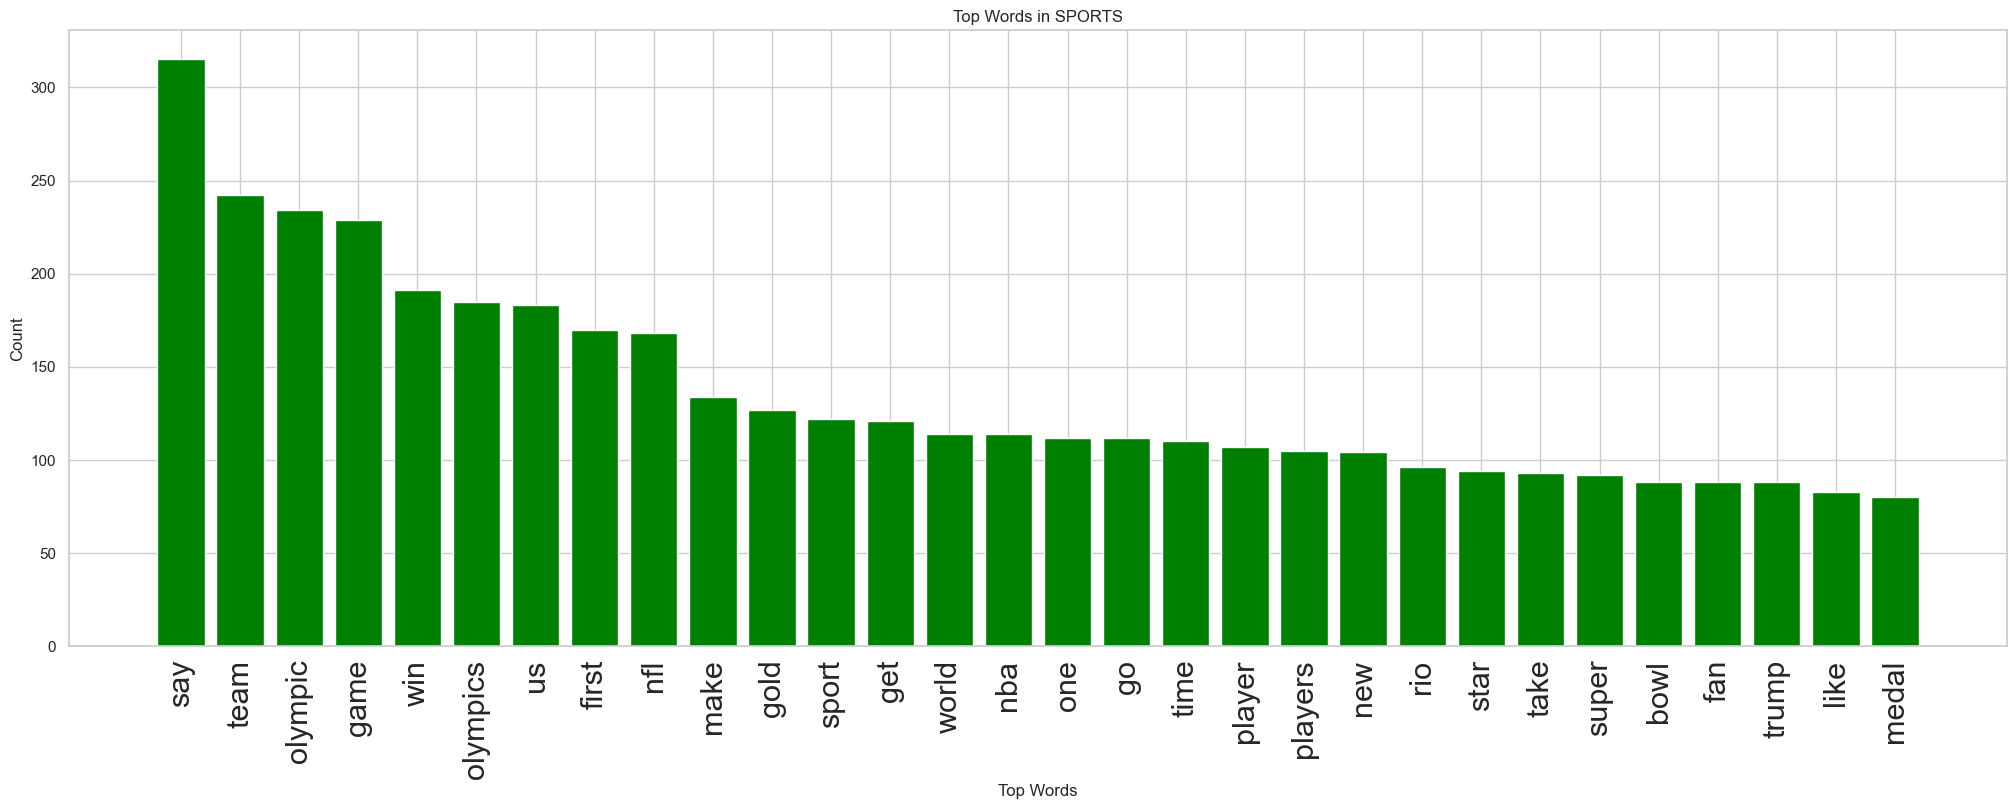

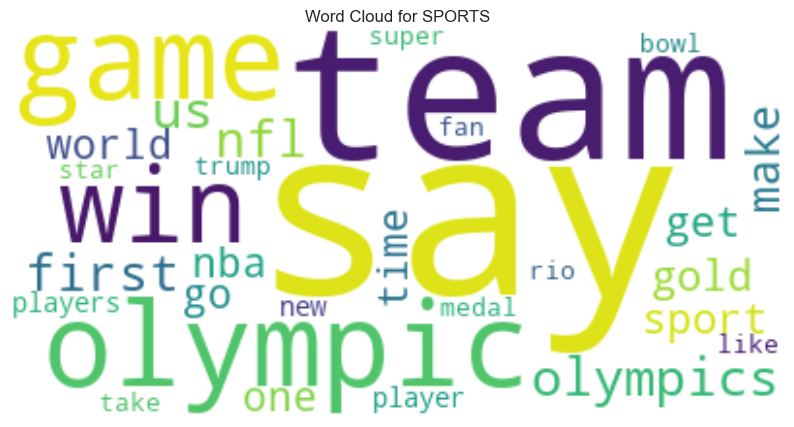

In [90]:
#Here for second category we are calling all the three function for creating the table, Bar graph and Word cloud
category = 'SPORTS'
top_sports = get_top_words_by_category(df, category, top_n=30)
display(top_sports.style.background_gradient(cmap='Greens'))
plot_top_words(top_sports, category)
generate_word_cloud(top_sports, category)

# POLITICS

,Top Words,Count
0,trump,1021
1,say,620
2,biden,358
3,president,322
4,house,258
5,gop,223
6,new,215
7,covid,204
8,former,199
9,donald,196


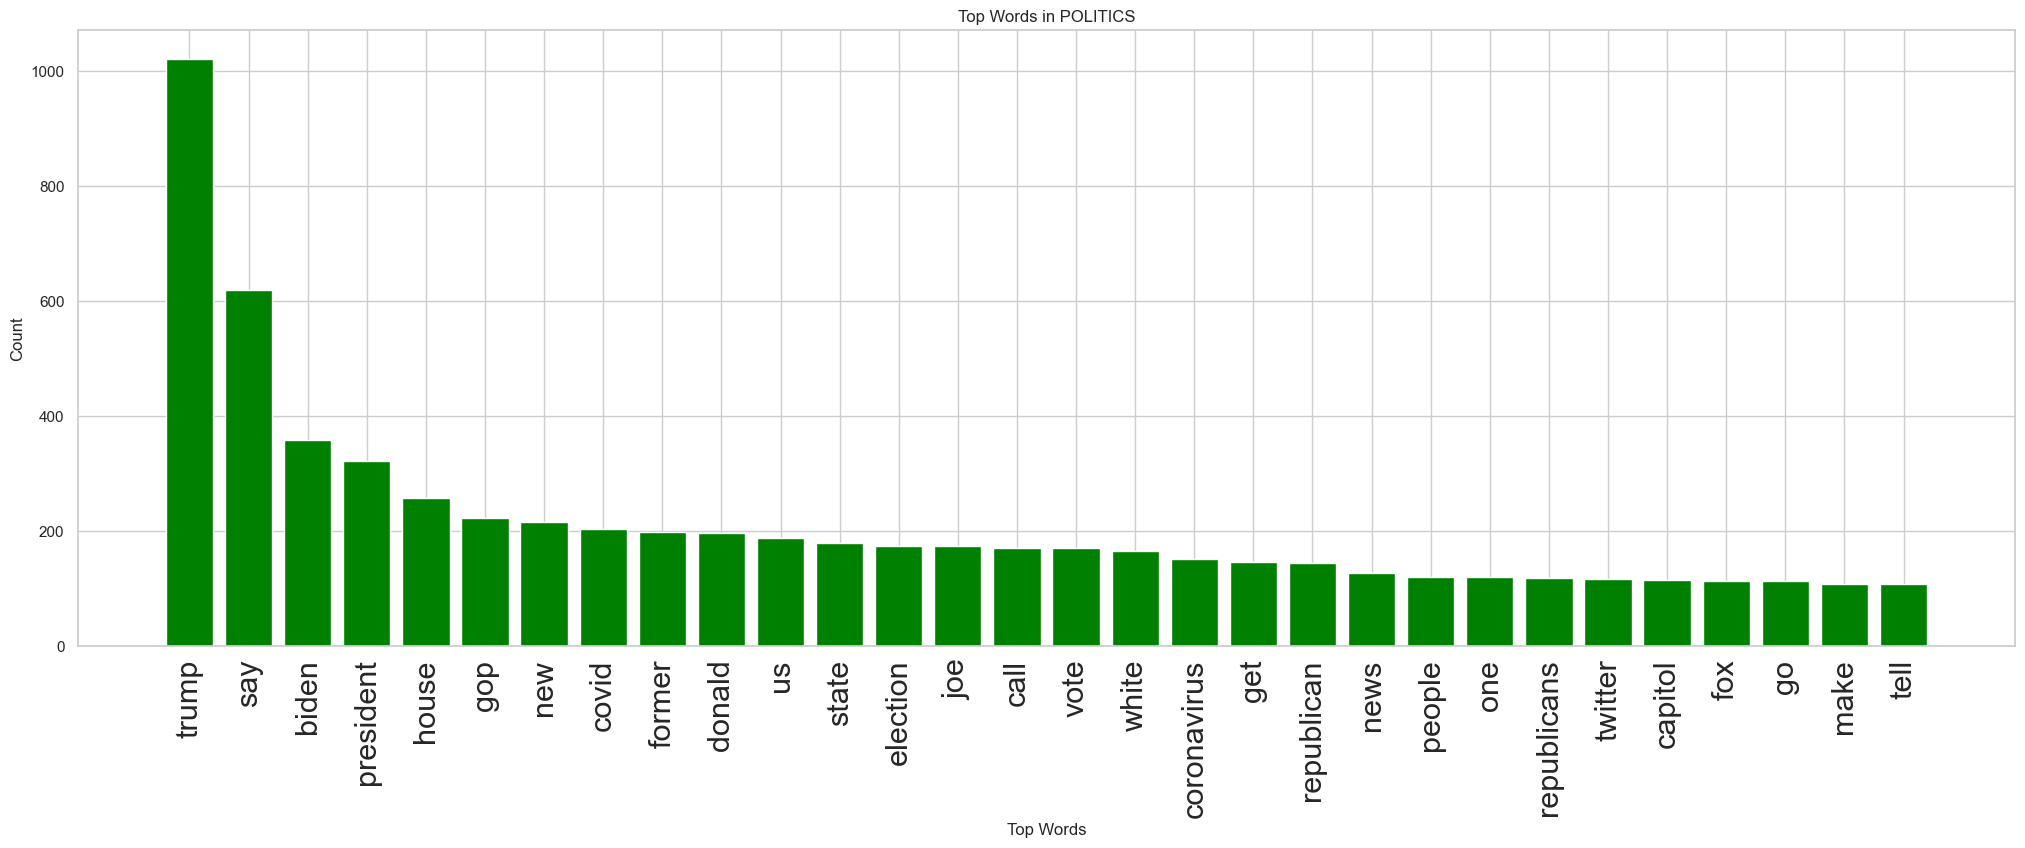

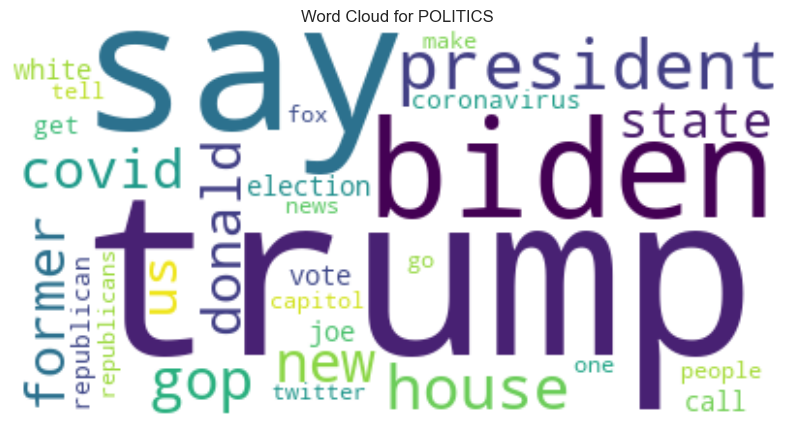

In [91]:
#Here for third category we are calling all the three function for creating the table, Bar graph and Word cloud
category = 'POLITICS'
top_politics = get_top_words_by_category(df, category, top_n=30)
display(top_politics.style.background_gradient(cmap='Greens'))
plot_top_words(top_politics, category)
generate_word_cloud(top_politics, category)

# ENTERTAINMENT

,Top Words,Count
0,say,420
1,star,333
2,show,280
3,new,279
4,actor,192
5,get,191
6,trump,185
7,make,147
8,host,122
9,first,116


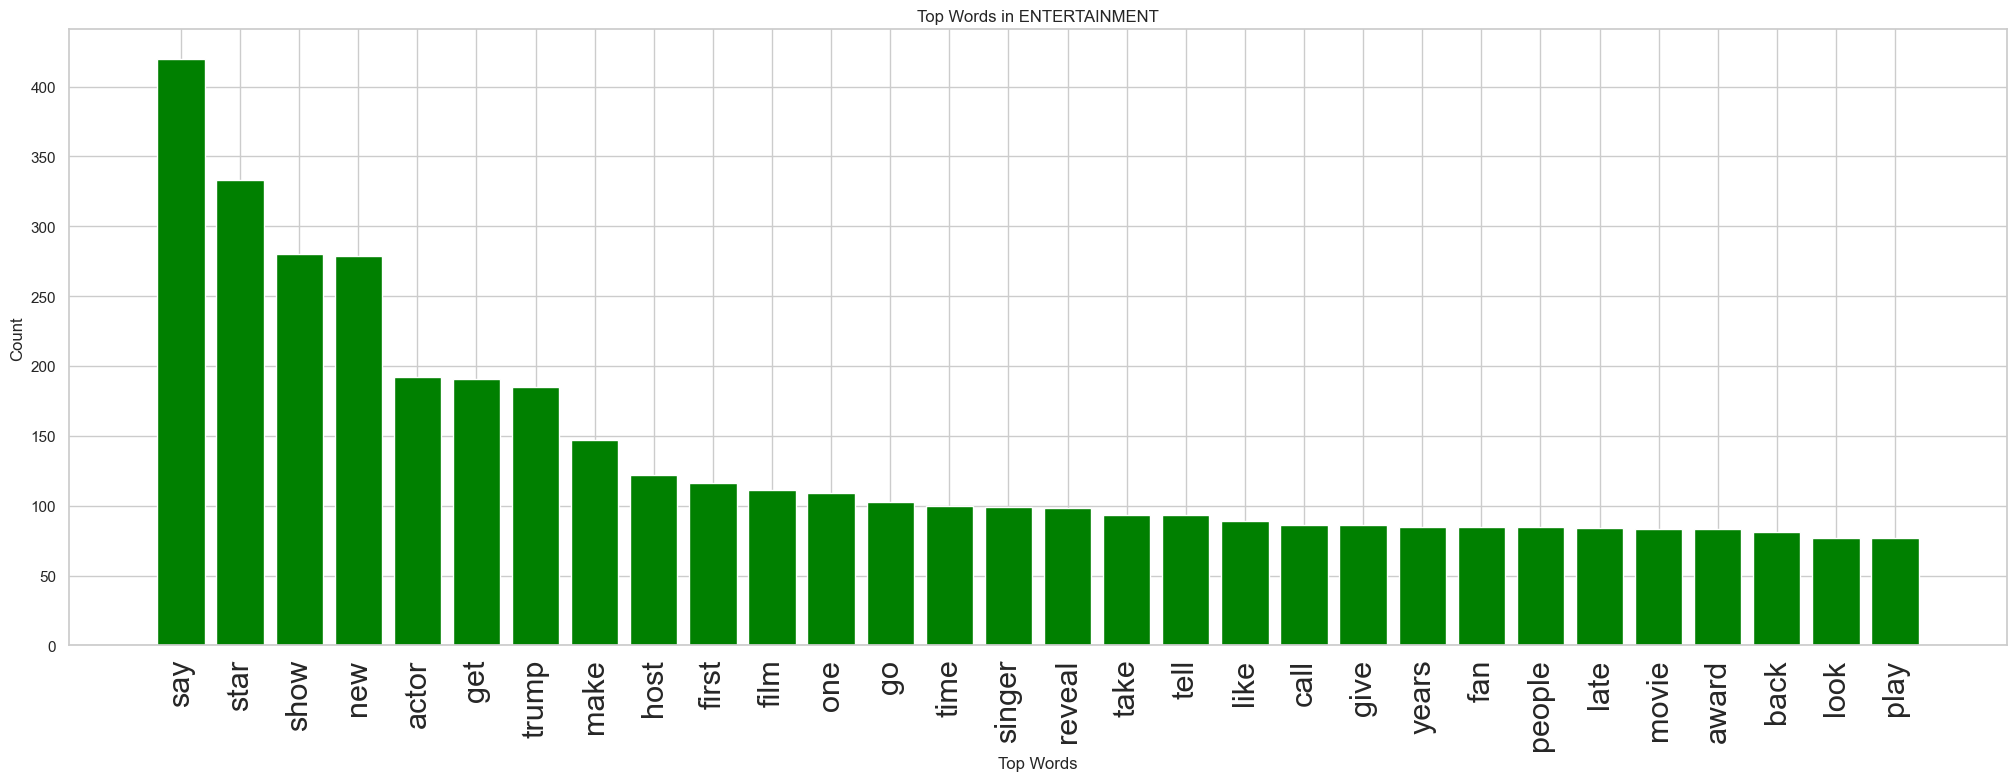

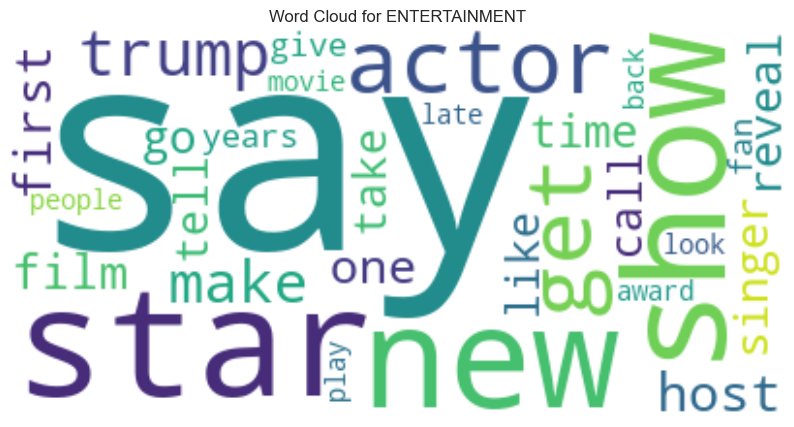

In [92]:
#Here for forth category we are calling all the three function for creating the table, Bar graph and Word cloud
category = 'ENTERTAINMENT'
top_entertainment = get_top_words_by_category(df, category, top_n=30)
display(top_entertainment.style.background_gradient(cmap='Greens'))
plot_top_words(top_entertainment, category)
generate_word_cloud(top_entertainment, category)

# BUSINESS

,Top Words,Count
0,company,298
1,new,218
2,say,214
3,us,178
4,make,174
5,get,172
6,job,140
7,people,135
8,work,133
9,business,128


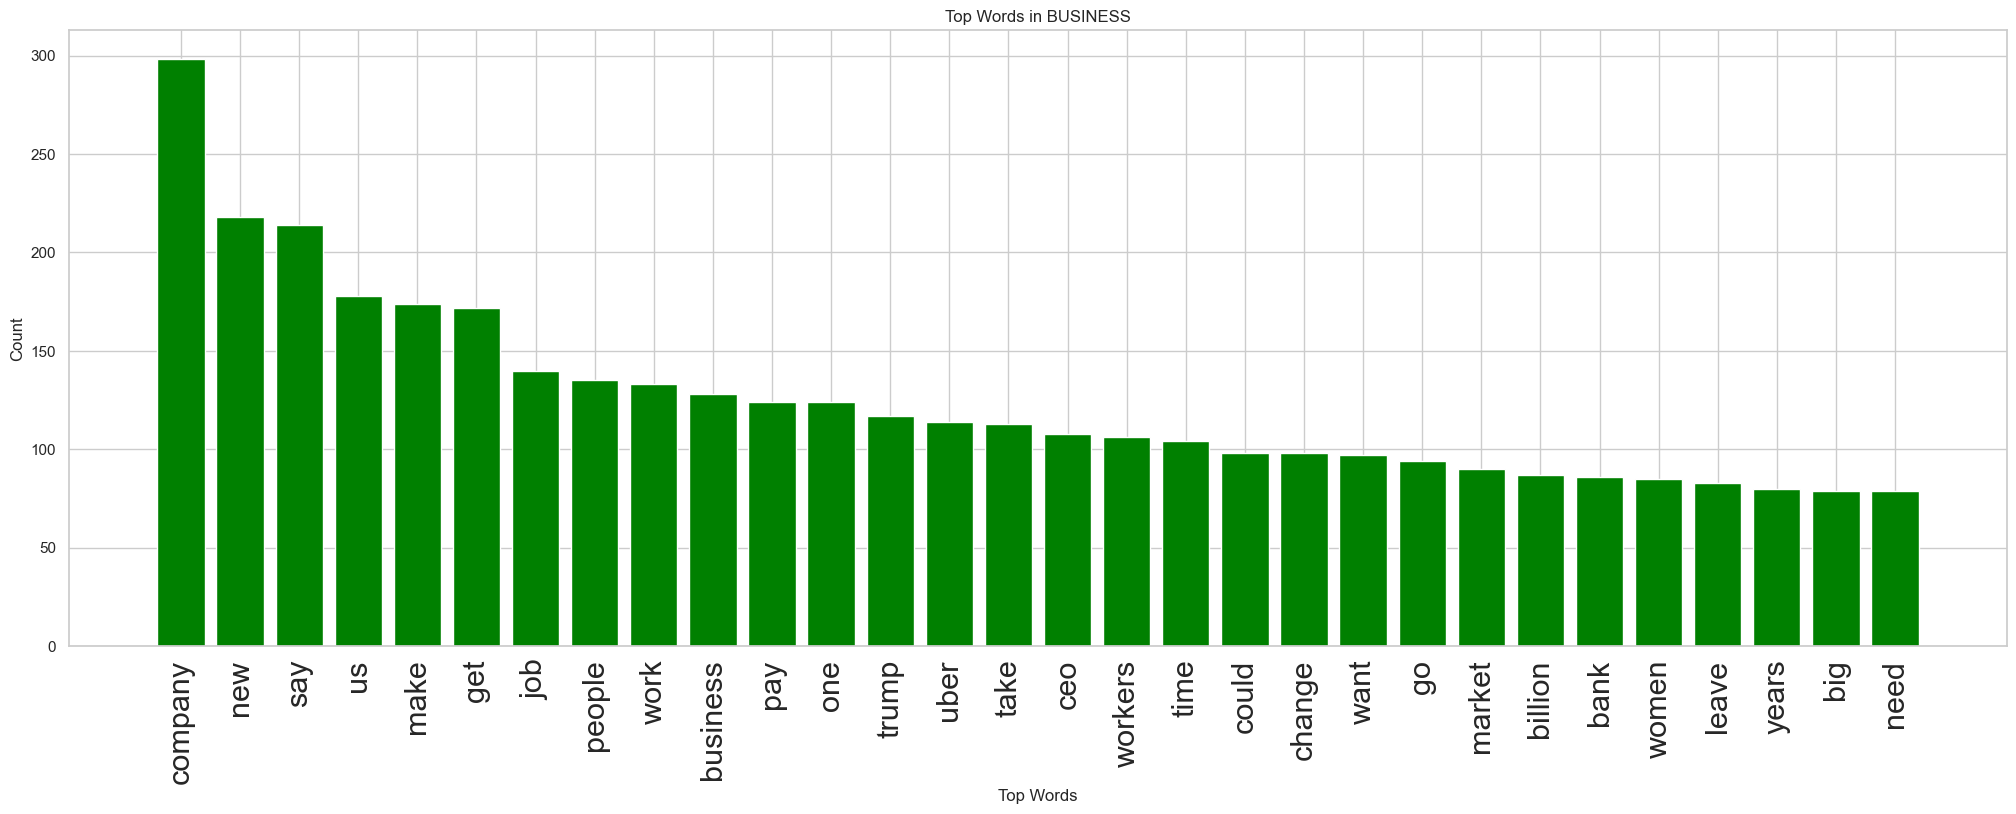

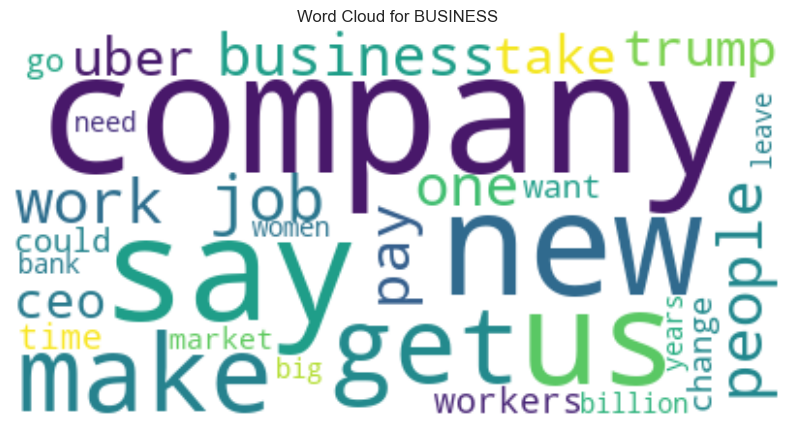

In [93]:
#Here for fifth category we are calling all the three function for creating the table, Bar graph and Word cloud
category = 'BUSINESS'
top_business = get_top_words_by_category(df, category, top_n=30)
display(top_business.style.background_gradient(cmap='Greens'))
plot_top_words(top_business, category)
generate_word_cloud(top_business, category)

## Spliting the data into Train and Test

In [94]:
# Before Splitting we see that our clean_text column is in list, so we have to 
# convert it to the String

In [95]:
df['clean_text']=df['clean_text'].apply(lambda x: ' '.join(x))

In [96]:
X=df['clean_text']
Y=df['encoded_category']

### Commenting out the code used for Nomalizing the features

In [97]:
# Although we have tried to apply the normalization to the text data column but there was no effect on
#accuracy of the result, Just for reference we have kept the code 

# from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
# cv = CountVectorizer()
# tfidf = TfidfVectorizer(max_features=3000)
# X = tfidf.fit_transform(df['clean_text']).toarray()
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

## Here spliting the data into Train and Test i.e 80:20 ratio, Then out of that Train we are spliting it into sub_Train and Validat into 60:20 ratio so that can train and test the model on this data and then lastly Test it on the Test data which the model has not seen

In [98]:
# Split data into train and test sets (80:20 ratio)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Further split train set into sub_train and validation sets (60:20 ratio)
X_sub_train, X_val, Y_sub_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

### Here aim is to Apply Different Vectorization techniques with Classification models and then compare the results

## Function for running all the models  it, also calculating the accuracy,precious,recall, f1score and confusion matrix

In [99]:
def evaluate_classification_model(classifier,X_sub_train, X_val, Y_sub_train, Y_val,X_test,Y_test):

    # Train the algorithm on the sub_train set
    classifier.fit(X_sub_train_bow, Y_sub_train)
    
    # Predict on the validation set
    Y_val_pred = classifier.predict(X_val_bow)

    # Calculate accuracy on the validation set
    validation_accuracy = accuracy_score(Y_val, Y_val_pred)
    validation_precision = precision_score(Y_val, Y_val_pred, average='macro')
    validation_recall = recall_score(Y_val, Y_val_pred, average='macro')
    validation_f1_score = f1_score(Y_val, Y_val_pred, average='macro')
    
    #confusion_matrix_val = confusion_matrix(Y_val, Y_val_pred)
    #conf_matrix(Y_val, Y_val_pred,'Confusion Matrix', category)    

    # Predict on the test set (unseen data)
    Y_test_pred = classifier.predict(X_test_bow)

    # Calculate accuracy on the test set
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    test_precision = precision_score(Y_test, Y_test_pred, average='macro')
    test_recall = recall_score(Y_test, Y_test_pred, average='macro')
    test_f1_score = f1_score(Y_test, Y_test_pred, average='macro')
    
    # Create a ddata frame with the metrics
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Training': [validation_accuracy, validation_precision, validation_recall, validation_f1_score],
        'Test': [test_accuracy, test_precision, test_recall, test_f1_score]
    })
    
    print(metrics_df)
    
    #Calling confusion matrix function
    confusion_matrix_val = confusion_matrix(Y_val, Y_val_pred)
    conf_matrix(Y_val, Y_val_pred,confusion_matrix_val)


## Bag Of Words

In [100]:
# creating object of Count Vectorizer
cv = CountVectorizer()

In [101]:
# parser matrix to numpy array 
X_sub_train_bow = cv.fit_transform(X_sub_train).toarray()
X_val_bow = cv.transform(X_val).toarray()
X_test_bow = cv.transform(X_test).toarray()

## Applying Gaussian Naive Bayes with Bag of Words

      Metric  Training      Test
0   Accuracy  0.713314  0.711856
1  Precision  0.715836  0.713739
2     Recall  0.714659  0.712374
3   F1 Score  0.712965  0.711651


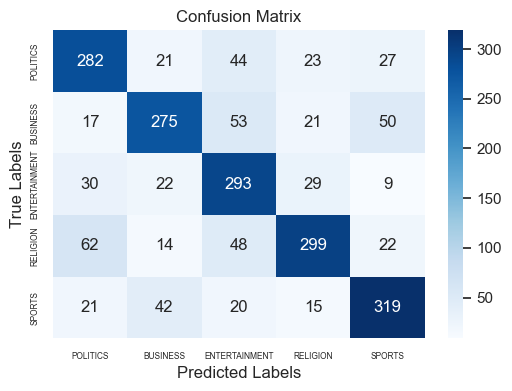

In [102]:
gnb = GaussianNB()
evaluate_classification_model(gnb, X_sub_train_bow, X_val_bow,Y_sub_train,Y_val, X_test_bow, Y_test)

## Random Forest Classifier with Bag of Words

      Metric  Training      Test
0   Accuracy  0.808066  0.803207
1  Precision  0.813920  0.812720
2     Recall  0.809540  0.803094
3   F1 Score  0.807793  0.803806


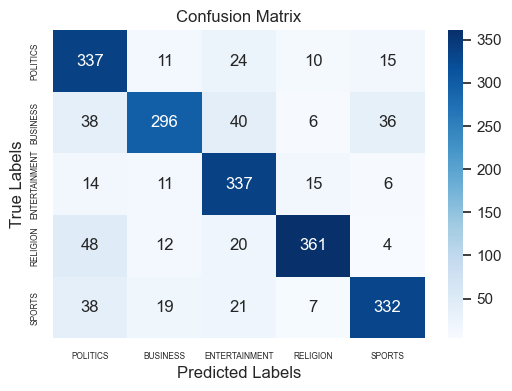

In [103]:
rf = RandomForestClassifier()
evaluate_classification_model(rf, X_sub_train_bow, X_val_bow,Y_sub_train,Y_val, X_test_bow, Y_test)

## Applying KNeighbors Classifier with Bag of Words

      Metric  Training      Test
0   Accuracy  0.283771  0.270165
1  Precision  0.684176  0.670040
2     Recall  0.273472  0.260756
3   F1 Score  0.187960  0.173409


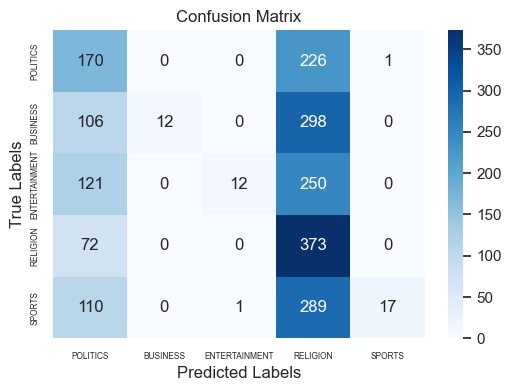

In [104]:
knn = KNeighborsClassifier()
evaluate_classification_model(knn, X_sub_train_bow, X_val_bow,Y_sub_train,Y_val, X_test_bow, Y_test)

## Applying Decision Tree Classifier with Bag of Words

      Metric  Training      Test
0   Accuracy  0.720603  0.706511
1  Precision  0.722945  0.710709
2     Recall  0.721562  0.706688
3   F1 Score  0.720839  0.707018


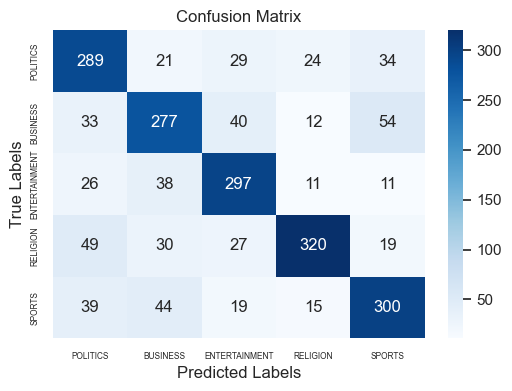

In [105]:
dt = DecisionTreeClassifier()
evaluate_classification_model(dt, X_sub_train_bow, X_val_bow,Y_sub_train,Y_val, X_test_bow, Y_test)

##  RandomForest Classifier N-grams 

      Metric  Training      Test
0   Accuracy  0.791059  0.793975
1  Precision  0.792103  0.794568
2     Recall  0.791512  0.793817
3   F1 Score  0.790237  0.793565


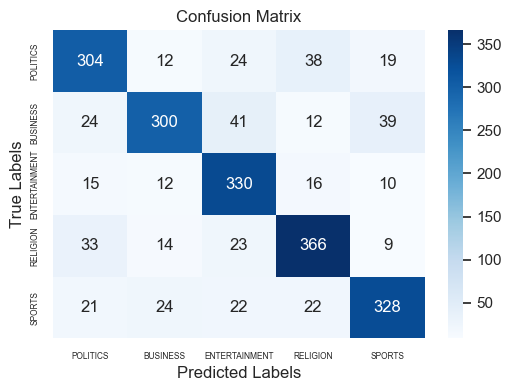

In [106]:
cv = CountVectorizer(ngram_range=(1,2),max_features=5000)

X_sub_train_bow = cv.fit_transform(X_sub_train).toarray()
X_val_bow = cv.transform(X_val).toarray()
X_test_bow = cv.transform(X_test).toarray()

rf = RandomForestClassifier()
evaluate_classification_model(rf, X_sub_train_bow, X_val_bow,Y_sub_train,Y_val, X_test_bow, Y_test)

# TFIDF

In [108]:
tfidf = TfidfVectorizer()
X_sub_train_bow = tfidf.fit_transform(X_sub_train).toarray()
X_val_bow = tfidf.transform(X_val).toarray()
X_test_bow = tfidf.transform(X_test).toarray()

## Apply Random Forest with TFIDF

      Metric  Training      Test
0   Accuracy  0.795918  0.800777
1  Precision  0.798273  0.805427
2     Recall  0.797383  0.801130
3   F1 Score  0.795395  0.801195


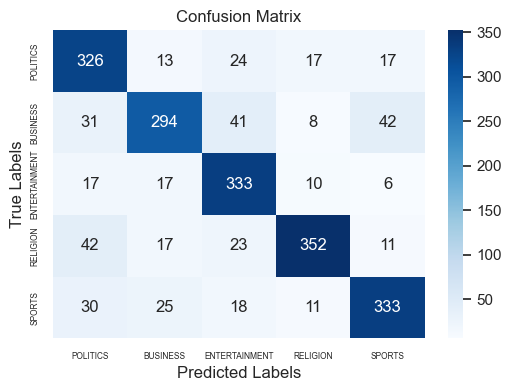

In [109]:
rf = RandomForestClassifier()

rf = RandomForestClassifier()
evaluate_classification_model(rf, X_sub_train_bow, X_val_bow,Y_sub_train,Y_val, X_test_bow, Y_test)

## Apply Gaussian Naive Bayes with TFIDF

      Metric  Training      Test
0   Accuracy  0.694363  0.680272
1  Precision  0.699480  0.686821
2     Recall  0.695035  0.681487
3   F1 Score  0.694439  0.680850


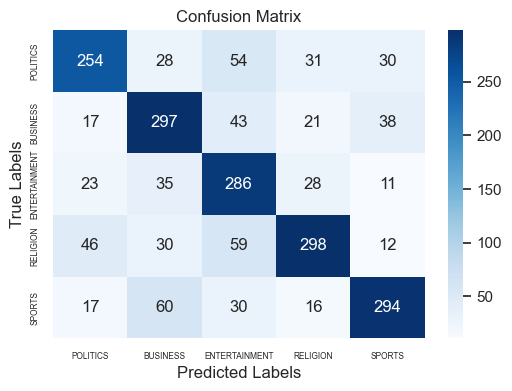

In [110]:
gnb = GaussianNB()
evaluate_classification_model(gnb, X_sub_train_bow, X_val_bow,Y_sub_train,Y_val, X_test_bow, Y_test)

## Apply KNeighbors Classifier with TFIDF

      Metric  Training      Test
0   Accuracy  0.768707  0.765306
1  Precision  0.776077  0.770315
2     Recall  0.769024  0.765117
3   F1 Score  0.769273  0.766032


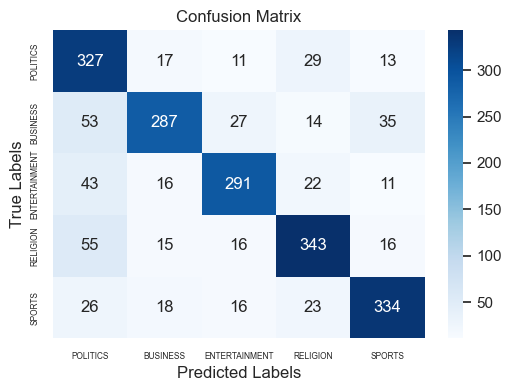

In [111]:
knc=KNeighborsClassifier()
evaluate_classification_model(knc, X_sub_train_bow, X_val_bow,Y_sub_train,Y_val, X_test_bow, Y_test)

## Apply Decision Tree Classifier with TFIDF

In [1]:
dtc=DecisionTreeClassifier()
evaluate_classification_model(dtc, X_sub_train_bow, X_val_bow,Y_sub_train,Y_val, X_test_bow, Y_test)


NameError: name 'DecisionTreeClassifier' is not defined

## Based on the results obtained from the evaluation of various models using different feature representations (Bag of Words and TF-IDF), the following observations can be made:

1. ***Random Forest Classifier models*** using Bag of Words and TF-IDF consistently achieved the ***highest accuracy*** (around 80%).
2. ***KNeighbors Classifier models*** showed lower accuracy (27% to 37%), indicating limited suitability for this task.
3. ***Gaussian Naive Bayes*** models performed moderately with accuracy ranging from 68% to 71%.
4. ***Decision Tree Classifier models*** had mixed results with accuracy ranging from 68% to 71%.
5. By looking at the Accuracy of Train and Test Data, it is noticed that there are no signs of ***overfitting*** or ***underfitting*** of data.
### Overall Random Forest Classifier models with Bag of Words, TF-IDF and N-Gram shown the promising results for this model.

## Recommendations for Future Enhancements:

To improve the model's performance, the following steps can be considered:

1. **Collecting more diverse and representative data:** Expanding the dataset with a wider range of samples can help the models learn more robust patterns and improve their generalization ability.

2. **Feature engineering and selection:** considering and exploring feature selection methods to focus on the most informative features for classification.

3. **Hyperparameter tuning:** Utilize techniques like grid search or random search to optimize the models' hyperparameters. This can lead to better performance and prevent overfitting or underfitting.